<a href="https://colab.research.google.com/github/shu0518/hw3_m11423036/blob/main/Hierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###匯入套件

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.cluster import AgglomerativeClustering # <--- 階層式分群
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment # 用於標籤匹配

###定義績效評估函式

In [ ]:
# 定義績效評估函式 (SSE, Entropy, Accuracy)

def calculate_sse(X, labels, n_clusters):
    """
    因為階層式分群沒有內建 inertia_，需手動計算 SSE。
    SSE = 所有資料點到其所屬群中心的距離平方和。
    """
    sse = 0.0
    for i in range(n_clusters):
        # 取出屬於第 i 群的資料點
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            # 計算該群的中心點 (Centroid)
            centroid = cluster_points.mean(axis=0)
            # 計算該群內所有點到中心的距離平方和
            sse += ((cluster_points - centroid) ** 2).sum()
    return sse

def calculate_entropy(labels_true, labels_pred):
    """計算分群結果的 Entropy，含防呆機制"""
    cm = confusion_matrix(labels_true, labels_pred)
    n_samples = np.sum(cm)
    entropy = 0.0

    for i in range(cm.shape[1]):
        cluster_total = np.sum(cm[:, i])
        if cluster_total > 0:
            p_j = cm[:, i] / cluster_total
            p_j = p_j[p_j > 0]
            e_j = -np.sum(p_j * np.log2(p_j))
            entropy += (cluster_total / n_samples) * e_j
    return entropy

def calculate_accuracy(labels_true, labels_pred):
    """計算分群準確度 (含匈牙利演算法標籤匹配)"""
    cm = confusion_matrix(labels_true, labels_pred)
    row_ind, col_ind = linear_sum_assignment(cm.max() - cm)
    accuracy = cm[row_ind, col_ind].sum() / cm.sum()
    return accuracy

def align_labels(labels_true, labels_pred):
    """
    [標籤對齊函式]
    將演算法的預測標籤 (1, 2, 3, 4) 轉換為最對應的真實標籤。
    讓畫圖時的顏色/編號與 Ground Truth 一致。
    """
    cm = confusion_matrix(labels_true, labels_pred)
    # 找出最佳對應 (row=真, col=預測)
    row_ind, col_ind = linear_sum_assignment(cm.max() - cm)

    # 建立對應字典 {預測: 真實}
    mapping = {col: row for row, col in zip(row_ind, col_ind)}

    # 置換標籤，若無對應則維持原樣
    new_labels = np.array([mapping.get(x, x) for x in labels_pred])
    return new_labels

###資料前處理

In [ ]:
# 資料前處理

# 1. 讀取資料
banana_df = pd.read_csv('https://raw.githubusercontent.com/shu0518/hw3_m11423036/refs/heads/main/banana.csv')
sizes3_df = pd.read_csv('https://raw.githubusercontent.com/shu0518/hw3_m11423036/refs/heads/main/sizes3.csv')

# 2. 切分特徵 (X) 與標籤 (y)
X_banana = banana_df[['x', 'y']].values
y_banana = banana_df['class'].values

X_sizes3 = sizes3_df[['x', 'y']].values
y_sizes3 = sizes3_df['class'].values

# 3. 資料標準化
scaler_banana = StandardScaler()
X_banana_std = scaler_banana.fit_transform(X_banana)

scaler_sizes3 = StandardScaler()
X_sizes3_std = scaler_sizes3.fit_transform(X_sizes3)

print("資料載入完成！")
print("-" * 30)
print(f"Banana 資料筆數: {len(banana_df)}")
print("Banana 類別分佈:")
print(banana_df['class'].value_counts().sort_index().to_string())
print("-" * 30)
print(f"Sizes3 資料筆數: {len(sizes3_df)}")
print("Sizes3 類別分佈:")
print(sizes3_df['class'].value_counts().sort_index().to_string())

資料載入完成！
------------------------------
Banana 資料筆數: 4811
Banana 類別分佈:
class
1    2520
2    2291
------------------------------
Sizes3 資料筆數: 1000
Sizes3 類別分佈:
class
0    667
1    111
2    111
3    111


###階層式分群執行與評估 - Banana 資料集


>>> Hierarchical: Banana Dataset
Time: 1.7853s | SSE: 4799.7781 | Accuracy: 0.7302 | Entropy: 0.8343


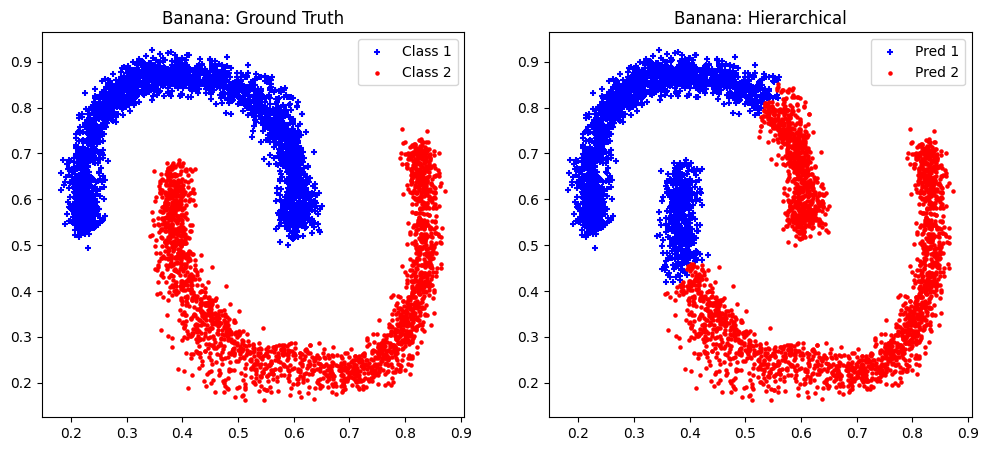

In [ ]:
# [Cell 4] 階層式分群執行 (Banana Dataset, k=2)

print("\n>>> Hierarchical: Banana Dataset")
hc_banana = AgglomerativeClustering(n_clusters=2, linkage='ward')

start = time.time()
pred_banana = hc_banana.fit_predict(X_banana_std)
time_banana = time.time() - start

# 計算指標 (需手動算 SSE)
sse_banana = calculate_sse(X_banana_std, pred_banana, n_clusters=2)
acc_banana = calculate_accuracy(y_banana, pred_banana)
ent_banana = calculate_entropy(y_banana, pred_banana)
print(f"Time: {time_banana:.4f}s | SSE: {sse_banana:.4f} | Accuracy: {acc_banana:.4f} | Entropy: {ent_banana:.4f}")

# 標籤對齊
aligned_banana = align_labels(y_banana, pred_banana)

# 畫圖 (Banana)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# 左圖：Ground Truth
ax[0].set_title("Banana: Ground Truth")
ax[0].scatter(X_banana[y_banana==1,0], X_banana[y_banana==1,1], s=20, c='b', marker='+', label='Class 1')
ax[0].scatter(X_banana[y_banana==2,0], X_banana[y_banana==2,1], s=5, c='r', marker='o', label='Class 2', facecolors='none', edgecolors='r')
ax[0].legend()

# 右圖：Hierarchical Result (Aligned)
ax[1].set_title("Banana: Hierarchical")
ax[1].scatter(X_banana[aligned_banana==1,0], X_banana[aligned_banana==1,1], s=20, c='b', marker='+', label='Pred 1')
ax[1].scatter(X_banana[aligned_banana==2,0], X_banana[aligned_banana==2,1], s=5, c='r', marker='o', label='Pred 2', facecolors='none', edgecolors='r')
ax[1].legend()
plt.show()

###階層式分群執行與評估 - Sizes3 資料集


>>> Hierarchical: Sizes3 Dataset
Time: 0.0379s | SSE: 431.8814 | Accuracy: 0.9700 | Entropy: 0.1929


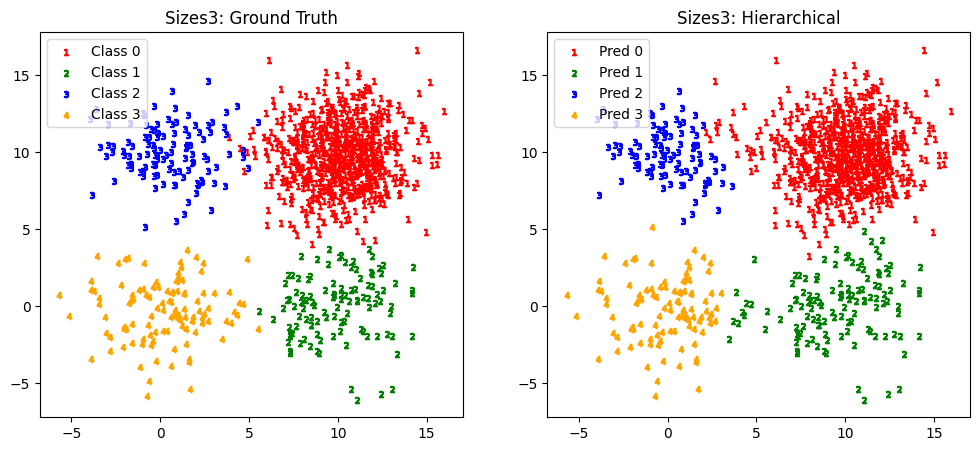

In [ ]:
# 階層式分群執行 (Sizes3 Dataset, k=4)

print("\n>>> Hierarchical: Sizes3 Dataset")
hc_sizes3 = AgglomerativeClustering(n_clusters=4, linkage='ward')

start = time.time()
pred_sizes3 = hc_sizes3.fit_predict(X_sizes3_std)
time_sizes3 = time.time() - start

# 計算指標
sse_sizes3 = calculate_sse(X_sizes3_std, pred_sizes3, n_clusters=4)
acc_sizes3 = calculate_accuracy(y_sizes3, pred_sizes3)
ent_sizes3 = calculate_entropy(y_sizes3, pred_sizes3)
print(f"Time: {time_sizes3:.4f}s | SSE: {sse_sizes3:.4f} | Accuracy: {acc_sizes3:.4f} | Entropy: {ent_sizes3:.4f}")

# 標籤對齊
aligned_sizes3 = align_labels(y_sizes3, pred_sizes3)

# 畫圖 (Sizes3)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
colors = ['r', 'g', 'b', 'orange']
markers = ['$1$', '$2$', '$3$', '$4$']

# 左圖：Ground Truth
ax[0].set_title("Sizes3: Ground Truth")
for i in range(4):
    ax[0].scatter(X_sizes3[y_sizes3==i,0], X_sizes3[y_sizes3==i,1], c=colors[i], marker=markers[i], s=20, label=f'Class {i}')
ax[0].legend()

# 右圖：Hierarchical Result (Aligned)
ax[1].set_title("Sizes3: Hierarchical")
for i in range(4):
    ax[1].scatter(X_sizes3[aligned_sizes3==i,0], X_sizes3[aligned_sizes3==i,1], c=colors[i], marker=markers[i], s=20, label=f'Pred {i}')
ax[1].legend()
plt.show()